In [1]:
import os
import yaml
import pickle

import numpy as np
import pandas as pd

import cv2
import math
import random

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import to_rgb

import zarr

from skimage.color import gray2rgb
from skimage.util.dtype import img_as_float

from IPython.display import display

In [2]:
def mse(image1, image2):
    
    # ensure images have the same shape
    assert image1.shape == image2.shape, "Images must have the same dimensions"

    # calculate squared differences between corresponding pixel values
    squared_diff = (image1.astype(np.float32) - image2.astype(np.float32)) ** 2

    # calculate the mean squared error
    mse_value = np.mean(squared_diff)

    return mse_value

In [3]:
def crop_vignette_mask(mask, size):
    
    # determine the center of the larger mask
    center = np.array(mask.shape) // 2
    
    # calculate half-size
    half_size = size // 2
    
    # define the range of indices for cropping
    start_x = max(0, center[0] - half_size)
    end_x = min(mask.shape[0], center[0] + half_size)
    start_y = max(0, center[1] - half_size)
    end_y = min(mask.shape[1], center[1] + half_size)
    
    # crop the larger array into the smaller mask
    cropped_mask = mask[start_x:end_x, start_y:end_y]
    
    # return the smaller mask
    return cropped_mask

In [4]:
def PlotInputImgs(window_size, std_dev, numExamples, numColumns, imgs, seg, intensity_multiplier, labels, fontSize, channel_color_dict, fileName, contrast_limits, save_dir):

    # create a range spanning 3 STDs below and above a mean value of zero
    x = np.linspace(0 - 3 * std_dev, 0 + 3 * std_dev, 100)  
    
    # find the number of intervals (pixels) needed to account for 3 STDs below and above the mean
    num_pixels = int(x.max() - x.min())
    
    # ensure num_pixels is odd so there are an equal number of pixels
    # to the left/right, top-bottom of center pixel after cropping the mask
    if num_pixels % 2 == 1:
        pass # number is already odd
    else:
        num_pixels + 1

    # create Gaussian kernel
    if num_pixels > window_size:
        kernel = cv2.getGaussianKernel(num_pixels, std_dev).astype('float32')
    else:
        kernel = cv2.getGaussianKernel(window_size, std_dev).astype('float32')

    # create 2D mask
    mask = (kernel * kernel.T)  
    
    # normalize mask pixel values 0-1
    mask = cv2.normalize(mask, None, 0, 1, cv2.NORM_MINMAX)
    
    # add a third dimension to mask (i.e. X, X, 1) for RGB
    mask = mask[:, :, np.newaxis]  

    vmin = mask.min()
    vmax = mask.max()
    
    if num_pixels > window_size:
        
        # crop the mask to desired cellcutter window size
        mask = crop_vignette_mask(mask=mask, size=window_size)
    
    ######################################################################################
    # plot Gaussian distribution
    
    fig3, ax4 = plt.subplots()
    offset = window_size // 2  # half window size in pixels
    
    # compute the maximum y-axis value of the Gaussian distribution curve
    x = np.linspace(0 - 3 * std_dev, 0 + 3 * std_dev, 100)
    p = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x - 0)**2 / (2 * std_dev**2))
    y_max = np.max(p)
    
    # compute the y-axis value at the 7-pixel cutoff points
    y_left = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-((0 - offset) - 0)**2 / (2 * std_dev**2))
    y_right = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-((0 + offset) - 0)**2 / (2 * std_dev**2))
    
    # plot the Gaussian distribution curve
    plt.plot(x, p, 'k', linewidth=2)
    
    # plot vertical red bars at one standard deviation to the left and right
    plt.axvline(x=0 - std_dev, color='red', linestyle='--')
    plt.text(0 - std_dev, 0, f'Std Dev: {0 - std_dev:.2f}', ha='center', va='bottom', rotation=90)
    
    plt.axvline(x=0 + std_dev, color='red', linestyle='--')
    plt.text(0 + std_dev, 0, f'Std Dev: {0 + std_dev:.2f}', ha='center', va='bottom', rotation=90)
    
    # plot vertical blue bars at 7 pixels to the left and right
    plt.axvline(x=0 - offset, color='blue', linestyle='--')

    plt.text(0 - offset, 0, f'7-Pixel Cutoff: {0 - offset:.2f}', ha='center', va='bottom', rotation=90)

    plt.axvline(x=0 + offset, color='blue', linestyle='--')
    plt.text(0 + offset, 0, f'7-Pixel Cutoff: {0 + offset:.2f}', ha='center', va='bottom', rotation=90)
    
    # plot horizontal lines at the maximum y-axis value and 7-pixel cutoff
    plt.axhline(y=y_max, color='black', linestyle='--', linewidth=1)
    plt.text(0 - 3 * std_dev, y_max, f'Max Density: {y_max:.4f}', ha='left', va='top')
    
    plt.axhline(y=y_left, color='black', linestyle='--', linewidth=1)
    plt.text(0 - 3 * std_dev, y_left, f'Density at 7-pixel distance: {y_left:.4f}', ha='left', va='bottom')
    
    plt.axhline(y=y_right, color='black', linestyle='--', linewidth=1)
    
    plt.title(
        f'Gaussian distribution, STD = {std_dev} pixels, Min value = {(y_left/y_max)*100:.1f}% of max',
        size=10
    )
    plt.xlabel('Pixel')
    plt.ylabel('Probability Density')
    display(fig3)
    fig3.savefig(os.path.join(save_dir, 'Gaussian_distribution.pdf'), bbox_inches='tight')
    
    ######################################################################################
    # show example images
    
    numRows = math.ceil(numExamples / numColumns)
    grid_dims = (numRows, numColumns)

    sns.set_style('whitegrid')
    fig1 = plt.figure(figsize=(20, 10))
    matplotlib.rcParams['font.family'] = 'Arial'
    
    for e, row in enumerate(labels.iterrows()):

        plt.subplot(grid_dims[0], grid_dims[1], e + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
       
        # initialize array of zeros with shape of full-size image
        overlay = np.zeros((imgs.shape[2], imgs.shape[3]))

        # add centroid point at the center of the image
        overlay[
            int(imgs.shape[2] / 2):int(imgs.shape[2] / 2) + 1,
            int(imgs.shape[3] / 2):int(imgs.shape[3] / 2) + 1
        ] = 1
        
        overlay = gray2rgb(overlay)
        
        for name, (ch, color) in channel_color_dict.items():

            lyr = img_as_float(imgs[ch, row[0], :, :])

            # apply image contrast settings
            lyr -= (contrast_limits[name][0] / 65535)
            lyr /= (contrast_limits[name][1] / 65535) - (contrast_limits[name][0] / 65535)
            lyr = np.clip(lyr, 0, 1)

            lyr = gray2rgb(lyr)
            lyr = lyr * to_rgb(color)
            
            overlay += lyr

            # select segmentation outlines slice
            seg_slice = seg[0, row[0], :, :]

            # ensure segmentation outlines are normalized 0-1
            seg_slice = (seg_slice - np.min(seg_slice)) / np.ptp(seg_slice)

            # convert segmentation thumbnail to RGB
            seg_slice = gray2rgb(seg_slice) * 1.0  # decrease alpha

        # overlay += seg_slice
        # overlay *= mask

        label = f'ID:{row[1]["CellID"]}'
        
        overlay = np.clip(overlay, 0, 1)  # avoiding matplotlib clipping warning
        plt.imshow(overlay, cmap=plt.cm.binary)
        plt.xlabel(label, size=fontSize, labelpad=1.5)

        if row[1]['CellID'] == 127525:
            
            ##############################################################
            # compare new mask to old mask
            
            kernel = cv2.getGaussianKernel(window_size, 18).astype('float32') 
            kernel = (kernel * kernel.T)
            
            # normalize the kernel 0-1
            mask_old = cv2.normalize(kernel, None, 0, 1, cv2.NORM_MINMAX)  
            
            # add a third dimension to mask (i.e. X, X, 1)
            mask_old = mask_old[:, :, np.newaxis]  
        
            # compute MSE between new and old masks
            res = mse(image1=mask, image2=mask_old)
            
            # visualize patches before and after vignetting
            print('Old')
            fig2, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(overlay)
            ax1.axis('off')
            ax1.set_title('Original')
            ax2.imshow(mask_old, cmap='Greys_r')
            ax2.axis('off')
            ax2.set_title('Mask')
            masked = np.clip(overlay * mask_old, 0, 1)
            ax3.imshow(masked)
            ax3.axis('off')
            ax3.set_title('Vignetted')
            plt.tight_layout() 
            display(fig2)
            fig2.savefig(os.path.join(save_dir, 'CellID_127525_old.pdf'), bbox_inches='tight')
            plt.close(fig2)
            
            # visualize patches before and after vignetting
            print('New')
            fig2, (ax1, ax2, ax3) = plt.subplots(1, 3)
            ax1.imshow(overlay)
            ax1.axis('off')
            ax1.set_title('Original')
            ax2.imshow(mask, cmap='Greys_r', vmin=vmin, vmax=vmax)
            ax2.axis('off')
            ax2.set_title('Mask')
            masked = np.clip(overlay * mask, 0, 1)
            ax3.imshow(masked)
            ax3.axis('off')
            ax3.set_title('Vignetted')
            plt.tight_layout() 
            display(fig2)
            fig2.savefig(os.path.join(save_dir, 'CellID_127525.pdf'), bbox_inches='tight')
            plt.close(fig2)

            print(f'MSE = {res}')
            
            ##############################################################

    legend_elements = []
    for name, (ch, color) in channel_color_dict.items():
        legend_elements.append(Line2D([0], [0], color=color, lw=5, label=name))

    fig1.legend(
        handles=legend_elements, prop={'size': 11}, bbox_to_anchor=(0.94, 0.99))

    fig1.subplots_adjust(bottom=0.01, top=0.99, left=0.01, right=0.85)
    fig1.savefig(os.path.join(save_dir, f'{fileName}.png'), dpi=800, bbox_inches='tight')
    plt.close('all')

In [5]:
# I/O
clustering = 'VAE9_ROT_VIG18'

main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))

root = os.path.join(os.getcwd(), f'input/{clustering}')

# read combined training, validation, and test thumbnails
z = zarr.open(os.path.join(root, '6_latent_space_LD184/combined_zarr'))

# read segmentation outlines for combined training, validation, and test thumbnails
z_seg = zarr.open(os.path.join(root, '6_latent_space_LD184/combined_zarr_seg'))

# read percentile cutoffs generated by feature_preprocessing_selections.py in VAE codebase
with open(os.path.join(root, '4_feature_preprocessing_selections/cutoffs.pkl'), 'rb') as handle:
    percentile_cutoffs = pickle.load(handle)

# image contrast settings
contrast_limits = yaml.safe_load(open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')))

# output directory
out = os.path.join(os.getcwd(), 'output/Gaussian_vignette')
if not os.path.exists(out):
    os.makedirs(out)

channel_color_dict = {
    'CD8a_660': [9, 'tab:red'],
    'CD4_488': [4, 'tab:green'],
    # 'Keratin_570': [2, 'tab:blue'],
    # 'aSMA_660': [3, 'tab:orange'],
    # 'CD20_488': [7, 'tab:blue'],
    # 'CD163_488': [10, 'tab:purple'],
    # 'FOXP3_570': [11, 'tab:pink'],
    # 'PCNA_488': [19, 'tab:red']
}

Example from VAE9_ROT_VIG18 Leiden cluster 16


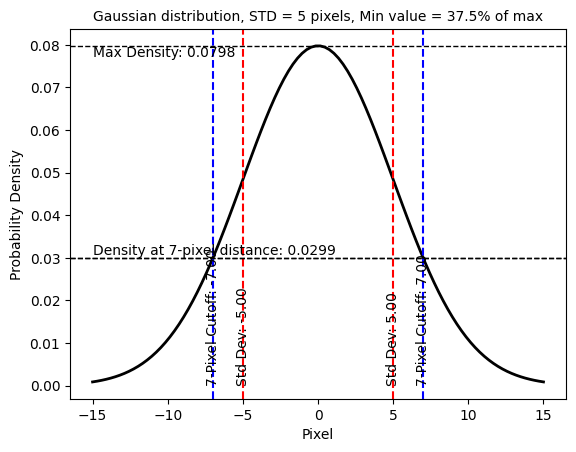

Old


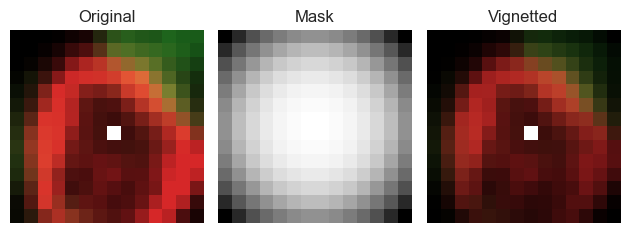

New


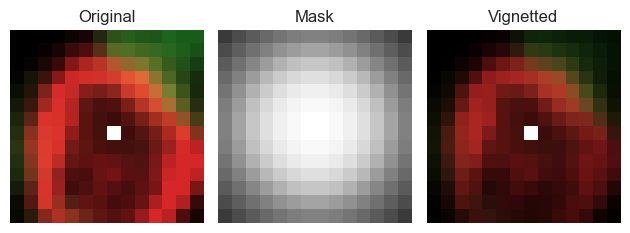

MSE = 0.004492465872317553


In [6]:
for cluster in [16]:  # list(range(0, 32))
    
    print(f'Example from VAE9_ROT_VIG18 Leiden cluster {cluster}')

    thumb_ids = main.index[main[clustering] == cluster]

    # grab examples
    gallery_size = 240
    random.seed(38)
    thumb_ids = random.sample(thumb_ids.tolist(), gallery_size)
    
    # slice main dataframe
    labels = main.iloc[thumb_ids].copy()
    labels.reset_index(drop=True, inplace=True)
    labels.sort_values(by=clustering, inplace=True)
    
    # slice zarr arrays
    imgs = z.get_orthogonal_selection((slice(None), thumb_ids))
    seg = z_seg.get_orthogonal_selection((slice(None), thumb_ids))

    window_size = 14  # in pixels
    std_dev = 5  # in pixels
    
    PlotInputImgs(
        window_size=window_size,
        std_dev=std_dev, 
        numExamples=gallery_size,
        numColumns=20,
        imgs=imgs,
        seg=seg,
        intensity_multiplier=1.0,
        labels=labels,
        fontSize=8,
        channel_color_dict=channel_color_dict,
        fileName=f'cluster{cluster}_thumbnails',
        contrast_limits=contrast_limits,
        save_dir=out
    )